# Análise exploratória dos dados

O primeiro passo será importar os dados e verificar a estrutura deles, após isso vou caminhar para a visualização que já possuo a intenção de fazer.

In [22]:
import pandas as pd
df = pd.read_csv("data/macros_dataset.csv")
df.head()

,food_name,proteins_100g,carbohydrates_100g,fat_100g,energy_100g,category_name,origin,diet_type
0,Alaskan salmon,25.4,0.0,6.7,170.0,Fish,Animal,Omnivorous
1,Almonds,21.3,19.7,50.6,577.0,Nuts,Non-animal,Vegan
2,Amaranth,14.5,66.2,6.5,374.0,Grains,Non-animal,Vegan
3,Anchovies,29.0,0.0,9.7,210.0,Fish,Animal,Omnivorous
4,Asparagus,2.4,4.1,0.2,22.0,Vegetables,Non-animal,Vegan


## Limpeza dos dados
Será necessário verificar se existem dados faltantes ou com problemas, se existirem, será necessário tratar esses dados.

There are 0 missing values in the dataset
There are 0 duplicate rows in the dataset
       proteins_100g  carbohydrates_100g   fat_100g  energy_100g
count      60.000000           60.000000  60.000000    60.000000
mean       19.263333           10.483333  13.256667   231.566667
std        10.176093           15.565348  16.035473   163.310935
min         2.000000            0.000000   0.200000    22.000000
25%        12.475000            0.375000   1.975000   114.000000
50%        21.000000            4.050000   6.450000   164.000000
75%        25.175000           15.825000  20.925000   314.250000
max        57.500000           67.400000  65.200000   653.000000
Categorias:
 ['Fish' 'Nuts' 'Grains' 'Vegetables' 'Fruits' 'Beans' 'Cheese' 'Seeds'
 'Meat' 'Legumes' 'Shellfish & Mollusks' 'Milk' 'Eggs' 'Soy Products'
 'Yogurts' 'Vegan Meat Substitute']


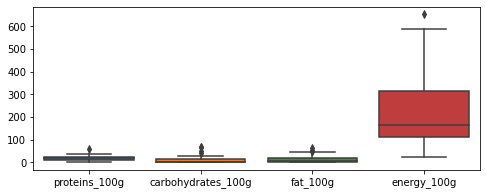

In [23]:
# let's see if there are any missing values
missing = df.isnull().sum().sum()
print("There are {} missing values in the dataset".format(missing))

# let's see if there are any duplicate rows
duplicates = df.duplicated().sum()
print("There are {} duplicate rows in the dataset".format(duplicates))

# let's see a summary of the dataset
print(df.describe())

# let's see the categories of the data
print("Categorias:\n", df["category_name"].unique())

# let's see if there are any outliers
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 3))
sns.boxplot(data=df)
plt.show()

# let's see the box plot again but only for the columns "proteins_100g", "carbohydrates_100g" and "fat_100g", and for the hover data we will use the "food_name" column
import plotly.express as px
fig = px.box(df, y=["proteins_100g", "carbohydrates_100g", "fat_100g"], hover_data=["food_name"])
fig.show()

# I could remove the "Spirulina (dried)" row, because it is an outlier, but I will not do it because I want to keep the original dataset
# df = df[df["food_name"] != "Spirulina (dried)"]

    

## Visualizações dos dados
Agora que os dados estão limpos, será possível fazer algumas visualizações para entender melhor os dados.

<AxesSubplot:ylabel='category_name'>

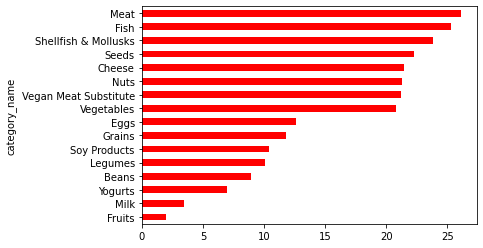

In [24]:
# let's see a horizontal bar plot of the mean protein_100g per category
df.groupby("category_name")["proteins_100g"].mean().sort_values().plot(kind="barh", color="red")

<AxesSubplot:ylabel='category_name'>

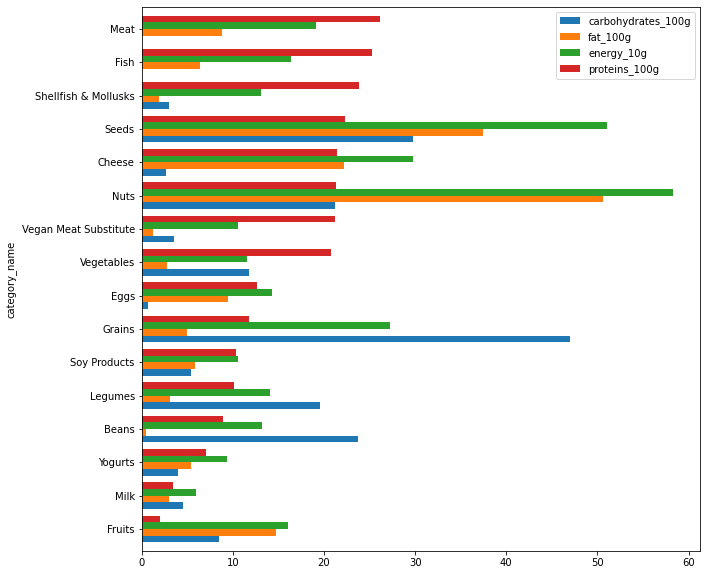

In [25]:
# let's create a new column with the energy / 100, because the energy have a very high value
df["energy_10g"] = df["energy_100g"] / 10

df.groupby("category_name")[["carbohydrates_100g", "fat_100g", "energy_10g", "proteins_100g"]].mean().sort_values(by="proteins_100g").plot(kind="barh", width=0.8, figsize=(10, 10))

## Visualização dos dados
Como estou tratando de alimentos, é interessante utilizar imagens para ilustrar cada alimento, para isso será necessário aprimorar nosso conjunto de dados com essas imagens já que ele não possui nada do tipo.

### Coluna `image_url`
A forma escolhida foi a criação de uma coluna `image_url` que contém o link para a imagem do alimento, para isso utilizei de web scraping para extrair os links do primeiro resultado da busca no Google Images para cada imagem do conjunto de dados (essa forma deve ser trocada, pois podem existir problemas com direitos autorais, mas foi uma maneira rápida de conseguir as imagens).

In [26]:
from bs4 import BeautifulSoup
import requests

DO_THE_SEARCH = False

def get_google_img(query):
    """
    gets a link to the first google image search result
    :param query: search query string
    :result: url string to first result
    """
    url = "https://www.google.com/search?q=" + str(query) + "&source=lnms&tbm=isch"
    headers={'User-Agent':"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.134 Safari/537.36"}

    html = requests.get(url, headers=headers).text

    soup = BeautifulSoup(html, 'html.parser')
    image = soup.select("a>div>img")[0]

    if not image:
        return 
    return image['src']

if DO_THE_SEARCH:
    # let's add the image url of each food_name+category_name to the dataframe
    df['image_url'] = df.apply(lambda x: get_google_img(x['food_name'] + " " + x['category_name']), axis=1)

    # let's manually change some urls that are not correct
    df.loc[df["food_name"] == "Lean Beef", "image_url"] = "https://bbqchamps.com/wp-content/uploads/2021/08/lean-beef-options-Tenderloin-Roast.png"


    # let's save the dataframe to a csv file
    df.to_csv("data/macros_dataset_images.csv", index=False)

### Distribuição dos alimentos
Agora que temos as imagens, podemos fazer uma visualização dos alimentos, para isso utilizei o `plotly` para fazer um scatter plot com as imagens dos alimentos.

Primeiro temos o plot base, e depois temos o plot com as imagens dos alimentos.

In [27]:
df = pd.read_csv("data/macros_dataset_images.csv")

color_sequence = [
    "#0077C9", # Fish
    "#8B4513", # Nuts
    "#F5E042", # Grains
    "#4EB265", # Vegetables
    "#FF0066", # Fruits
    "#9E005D", # Beans
    "#FFCF48", # Cheese
    "#6F6F6F", # Seeds
    "#EC7357", # Meat
    "#009E49", # Legumes
    "#00B6CB", # Shellfish & Mollusks
    "#F7E5D5", # Milk
    "#F8E9A1", # Eggs
    "#A5A052", # Soy Products
    "#FFC0CB", # Yogurts
    "#B2B2B2"  # Vegan Meat Substitute
]


import plotly.express as px
# let's make a scatter plot of the fat_100g and the proteins_100g grouped by category_name
fig = px.scatter(df, 
    x="fat_100g",
    y="proteins_100g",
    color="category_name",
    hover_name="food_name",
    size="energy_100g",
    size_max=20,
    title="Fat vs Proteins",
    labels={"fat_100g":"Fat (g)", "proteins_100g":"Proteins (g)", "energy_100g":"Energy (kcal)"},
    width=1000,
    height=550,
    color_discrete_sequence=color_sequence,
    custom_data=["energy_100g", "image_url"],
    hover_data={"image_url":True, "energy_100g":True})
# let's make the dots bigger
fig.update_traces(marker=dict(size=10))

# let's change the hover template
fig.update_traces(hovertemplate="<b>%{hovertext}</b><br><br>" +
                    "Fat: %{x:.2f}g<br>" + 
                    "Proteins: %{y:.2f}g<br>" +
                    "Energy: %{customdata[0]:.2f}kcal<br>" +
                    "" +
                    "<extra><img src='%{customdata[1]}'></extra>") # the hover templat doesn't work with the img tag

# let's change plotly's menu
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            buttons=list([
                dict(
                    args=[{"xaxis.type": "linear"}],
                    label="Linear",
                    method="relayout"
                ),
                dict(
                    args=[{"xaxis.type": "log"}],
                    label="Log",
                    method="relayout"
                )
            ]),
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
    ]
)

fig.update_layout(
    dragmode="zoom",
    hovermode="closest",
    hoverdistance=100,
    spikedistance=200,
    showlegend=False,
    xaxis=dict(
        title="Fat (g)",
        tickfont=dict(
            family="Arial",
            size=12,
            color="#999999"
        )
    ),
    yaxis=dict(
        title="Proteins (g)",
        tickfont=dict(
            family="Arial",
            size=12,
            color="#999999"
        )
    ),
    font=dict(
        family="Arial",
        size=12,
        color="#999999"
    )
)

# let's remove the option to Box Select and Lasso Select from the plotly menu
fig.update_layout(
    hovermode="closest",
    hoverdistance=100,
    spikedistance=200
)

# export the figure to a html file
fig.write_html("fat_vs_proteins.html")


fig.show()

In [29]:
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, no_update
import plotly.graph_objects as go
# let's make a scatter plot of the fat_100g and the proteins_100g grouped by category_name
fig = px.scatter(df, x="fat_100g", y="proteins_100g", color="category_name", hover_name="food_name",
    size="energy_100g", title="Fat vs Proteins (100g)", labels={"fat_100g":"Fat (g)", "proteins_100g":"Proteins (g)", "energy_100g":"Energy (kcal)"},
    width=1200, height=600, color_discrete_sequence=color_sequence,
    custom_data=["energy_100g", "image_url", "fat_100g", "proteins_100g", "energy_100g", "carbohydrates_100g", "category_name"], hover_data={"image_url":True, "energy_100g":True})
# let's make the dots bigger
fig.update_traces(marker=dict(size=10))

fig.update_traces(hoverinfo="none", hovertemplate=None)

fig.update_layout(modebar_remove=['select', 'autoScale', 'lasso2d'])
# change the default behavior to pan
fig.update_layout(dragmode="pan")

app = JupyterDash(__name__)

app.layout = html.Div([
    html.H1("Visualização da Informação"),
    html.H2("Por: Lucas Treuke"),
    dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
    dcc.Tooltip(id="graph-tooltip"),
], style={
    "font-family": "Helvetica, sans-serif",
    "margin": "10px",
})


@app.callback(
    Output("graph-tooltip", "show"),
    Output("graph-tooltip", "bbox"),
    Output("graph-tooltip", "children"),
    Input("graph", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    pt = hoverData["points"][0]
    bbox = pt["bbox"]

    img_src = pt["customdata"][1]
    fat_100g = pt["customdata"][2]
    proteins_100g = pt["customdata"][3]
    energy_100g = pt["customdata"][4]
    carbohydrates_100g = pt["customdata"][5]
    category_name = pt["customdata"][6]
    name = pt["hovertext"]

    children = [
        html.Div(children=[
            html.H2(f"{name}", style={"color": "black", "font-family": "Arial"}),
            html.Img(src=img_src, style={"width": "100%"}),
            html.P(children=[
                html.Span("⬤  ", style={"color": color_sequence[pt["curveNumber"]]}),
                html.Span(f"{category_name}")
                ], style={"color":"#111", "font-family": "Arial", "margin-top":"3px", "border-top": "1px solid #888", "font-weight": "bold"}),
            html.P(f"Quantity: 100g",style={"color":"#333", "font-family": "Arial"}),
            html.P(f"Fat: {fat_100g}g",style={"color":"#333", "font-family": "Arial"}),
            html.P(f"Proteins: {proteins_100g}g",style={"color":"#333", "font-family": "Arial"}),
            html.P(f"Energy: {energy_100g}kcal",style={"color":"#333", "font-family": "Arial"}),
            html.P(f"Carbohydrates: {carbohydrates_100g}g",style={"color":"#333", "font-family": "Arial"})
        ],
        style={'width': '200px', 'white-space': 'normal'})
    ]

    return True, bbox, children



# app.run_server(debug=True, mode='inline')
app.run_server(mode="inline", port=8051, debug=True, dev_tools_ui=False, dev_tools_props_check=False)